First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-01-13 15:39:55.550094: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 15:39:55.552630: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 15:39:55.556364: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 15:39:55.566458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736800795.584191  601973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736800795.58

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# for function later

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
yList= np.column_stack((burn_label,un_label,duration_label))# y list is a 2D array, each column is a response outcome

In [6]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

In [7]:
data_train, data_test, y_train, y_test = RunML_continue.split_and_scale_data(data,burn_label)
AE_train, AE_test = RunML_continue.run_AE(data_train,data_test)
data_AE = pd.concat([AE_train, AE_test], axis=0).to_numpy()

2025-01-13 15:39:58.183478: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


latent dimension: 100, activation:tanh, opt:adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [8]:
data_AE.shape

(59, 100)

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

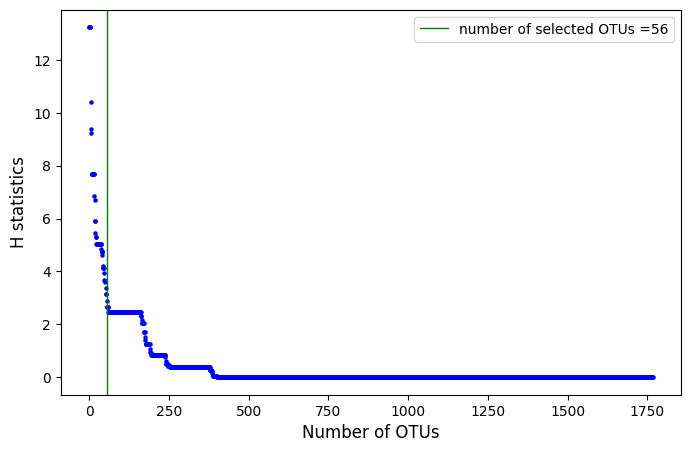

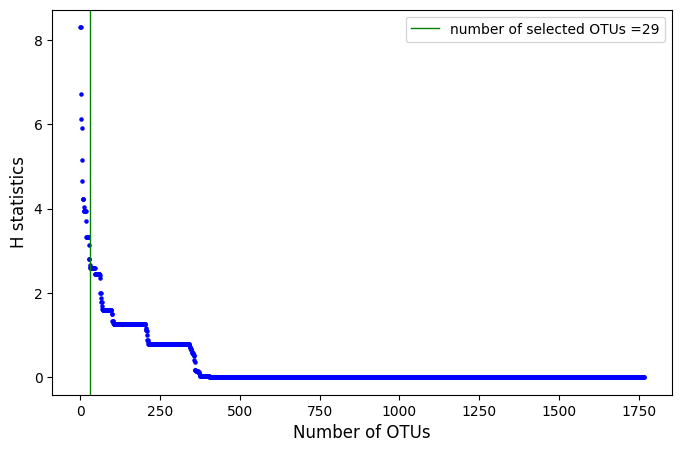

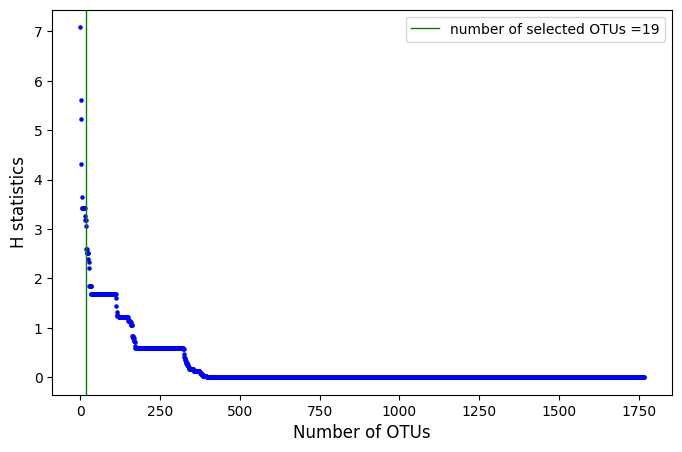

In [9]:
# select the OTUs
selected_list = []
for i in range(yList.shape[1]):
    selectedresult=FS.SelectMicro_fun(df,yList[:,i])
    selected_list.append(selectedresult)
selected_list[0].keys()

In [10]:
selectedOTU_index_list = [item['selected_indices'] for item in selected_list]
selectedASV_list = [item['selected_columnames'] for item in selected_list]
X_FS_list = [item['selected_data'] for item in selected_list]
data = selected_list[0]['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [11]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]


In [17]:
dict_cm_list = []

for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    print("The response variable and its counts are:")
    print(pd.Series(yList[:,i]).value_counts())

    data_subset = {"AllFeatures":data}
    
    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)
    print(metric.metric_sum(dict_cm))
    dict_cm_list.append(dict_cm)



The response variable and its counts are:
Yes    42
No     17
Name: count, dtype: int64
             RF_Accuracy    RF_AUC  SVM_Accuracy  SVM_AUC  CatBoost_Accuracy  \
AllFeatures     0.780303  0.922917       0.74697  0.84375           0.845455   

             CatBoost_AUC  NB_Accuracy    NB_AUC  
AllFeatures      0.887037     0.863636  0.801389  
                      Accuracy  Precision    Recall  Specification       Mcc
AllFeatures_RF        0.779661   1.000000  0.235294       1.000000  0.423886
AllFeatures_SVM       0.745763   0.571429  0.470588       0.857143  0.348896
AllFeatures_CatBoost  0.847458   1.000000  0.470588       1.000000  0.622530
AllFeatures_NB        0.864407   0.846154  0.647059       0.952381  0.655004
The response variable and its counts are:
Urban      33
Natural    26
Name: count, dtype: int64
             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC  CatBoost_Accuracy  \
AllFeatures     0.556061  0.702698      0.556061  0.424444           0.524242   

     

In [12]:
dict_cm_list = []

for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    print("The response variable and its counts are:")
    print(pd.Series(yList[:,i]).value_counts())
    
    X_FS = X_FS_list[i]

    data_subset = {"AllFeatures":data, 
           "SelectMicro": X_FS,
           "AE":data_AE
          }
    print(f'The shape of the original dataset is ',np.shape(data))
    print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
    print(f'The shape of the AE dataset is ',np.shape(data_AE))
    
    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)
    print(metric.metric_sum(dict_cm))
    dict_cm_list.append(dict_cm)


  

The response variable and its counts are:
Yes    42
No     17
Name: count, dtype: int64
The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 56)
The shape of the AE dataset is  (59, 100)


TBB Warning: The number of workers is currently limited to 0. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC  CatBoost_Accuracy  \
AllFeatures     0.780303  0.922917      0.746970  0.843750           0.845455   
SelectMicro     0.896970  0.977778      0.698485  0.899306           0.878788   
AE              0.762121  0.705671      0.371212  0.356019           0.693939   

             CatBoost_AUC  NB_Accuracy    NB_AUC  
AllFeatures      0.887037     0.863636  0.801389  
SelectMicro      0.962269     0.933333  0.940278  
AE               0.715972     0.406061  0.658333  
                      Accuracy  Precision    Recall  Specification       Mcc
AllFeatures_RF        0.779661   1.000000  0.235294       1.000000  0.423886
AllFeatures_SVM       0.745763   0.571429  0.470588       0.857143  0.348896
AllFeatures_CatBoost  0.847458   1.000000  0.470588       1.000000  0.622530
AllFeatures_NB        0.864407   0.846154  0.647059       0.952381  0.655004
SelectMicro_RF        0.898305   1.000000  0.647059       1.000000  0.752447
SelectMic

In [14]:
dict_cm_0 = RunML_continue.ML_model_SCV(data, burn_label, "RF", SMOTE=True,k=5)
print(dict_cm_0)

{'mean_accuracy': 0.7803030303030304, 'mean_auc': 0.9229166666666668, 'y_true': ['No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No'], 'y_pred': ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No'], 'y_pred_prob': [0.6, 0.59, 0.67, 1.0, 1.0, 0.97, 0.84, 0.76, 0.75, 1.0, 0.91, 0.92, 0.83, 0.94, 0.99,

In [15]:
selectedASV_list[0]

Index(['ASV66', 'ASV81', 'ASV85', 'ASV141', 'ASV148', 'ASV43', 'ASV73',
       'ASV38', 'ASV139', 'ASV154', 'ASV174', 'ASV181', 'ASV208', 'ASV216',
       'ASV263', 'ASV272', 'ASV94', 'ASV7', 'ASV3', 'ASV19', 'ASV45', 'ASV11',
       'ASV24', 'ASV91', 'ASV133', 'ASV146', 'ASV150', 'ASV159', 'ASV191',
       'ASV207', 'ASV225', 'ASV274', 'ASV315', 'ASV335', 'ASV338', 'ASV348',
       'ASV369', 'ASV384', 'ASV51', 'ASV5', 'ASV13', 'ASV18', 'ASV2', 'ASV30',
       'ASV104', 'ASV183', 'ASV231', 'ASV27', 'ASV8', 'ASV15', 'ASV26', 'ASV1',
       'ASV79', 'ASV54', 'ASV59', 'ASV32'],
      dtype='object')

In [16]:
selectedOTU_index_FS_lassoft_list

NameError: name 'selectedOTU_index_FS_lassoft_list' is not defined

In [ ]:
selectedOTU_index_FS_lassoft_list[0]

## compare the first 20 index

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements

entries=20

selectedOTU_index_15_list=[arr[:entries] for arr in selectedOTU_index_list]

selectedASVs20_list = []
for i in range(yList.shape[1]):
    selectedASVs = ASVs[selectedOTU_index_15_list[i]]
    selectedASVs20_list.append(selectedASVs)

In [ ]:
targetLabel=burn_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[0]],yList[:,0],selectedASVs20_list[0],
                     posLabel="Yes",posText="Burned",negText="Not Burned")
FS.plotPresenseRatio(X_lassoft_list[0],yList[:,0],ASVs[selectedOTU_index_lassoft_list[0]],
                     posLabel="Yes",posText="Burned",negText="Not Burned")

FS.plotPresenseRatio(X_FS_list[0][:,selectedOTU_index_FS_lassoft_list[0]],yList[:,0],selectedASV_list[0][selectedOTU_index_FS_lassoft_list[0]],
                     posLabel="Yes",posText="Burned",negText="Not Burned")

In [ ]:
targetLabel=un_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[1]],yList[:,1],selectedASVs20_list[1],
                     posLabel="Natural",posText="Natural",negText="Urban")

FS.plotPresenseRatio(X_lassoft_list[1],yList[:,1],ASVs[selectedOTU_index_lassoft_list[1]],
                    posLabel="Natural",posText="Natural",negText="Urban")
FS.plotPresenseRatio(X_FS_list[1][:,selectedOTU_index_FS_lassoft_list[1]],yList[:,1],selectedASV_list[1][selectedOTU_index_FS_lassoft_list[1]],
                     posLabel="Natural",posText="Natural",negText="Urban")

In [ ]:
targetLabel=duration_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[2]],yList[:,2],selectedASVs20_list[2],
                    posLabel="Annual",posText="Annual",negText="Perennial")
FS.plotPresenseRatio(X_lassoft_list[2],yList[:,2],ASVs[selectedOTU_index_lassoft_list[2]],
                    posLabel="Annual",posText="Annual",negText="Perennial")
FS.plotPresenseRatio(X_FS_list[2][:,selectedOTU_index_FS_lassoft_list[2]],yList[:,2],selectedASV_list[2][selectedOTU_index_FS_lassoft_list[2]],
                     posLabel="Annual",posText="Annual",negText="Perennial")

In [ ]:
X_FS_list[2][:,selectedOTU_index_FS_lasso_list[2]].shape

In [ ]:
len(selectedASV_list[2][selectedOTU_index_FS_lassoft_list[2]])

In [ ]:
len(selectedOTU_index_FS_lasso_list[2])

In [ ]:
selectedASV_list[2]

In [ ]:
selectedOTU_index_FS_lassoft_list[2]